# Introduction to Reinforcement Learning and Q-Learning

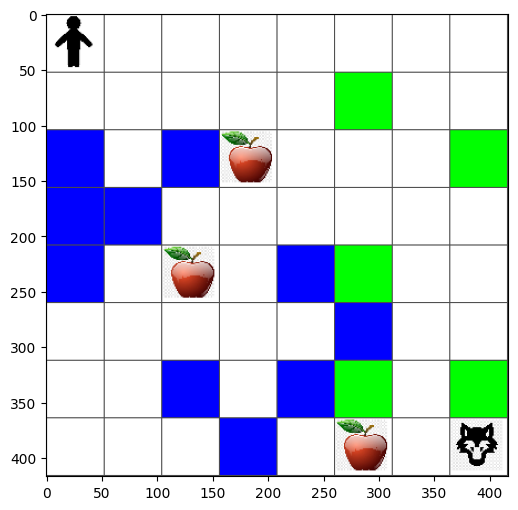

In [12]:
from rlboard import *

width, height = 8, 8
m = Board(width, height)
m.randomize(seed=13)
m.plot()

Each cell in this board can either be:
    - ground, on which Peter and other creatures can walk.
    - water, on which you obviously cannot walk.
    - a tree or grass, a place where you can rest.
    - an apple, which represents something Peter would be glad to find in order to feed himself.
    - a wolf, which is dangerous and should be avoided.


### Actions and policy

In this case Peter's goal would be able to find and apple, while avoiding the wolf and other obstacles. To do this, he can essentially walk around until he finds an apple.

Therefore, at any position, he can choose between one of the following actions: up, down, left and right.

We will define those actions as a dictionary, and map them to pairs of corresponding coordinate changes. For example, moving right (`R`) would correspond to a pair `(1, 0)`. 

In [13]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

To sum up, the strategy and goal of this scenario are as follows:
- **The strategy** of our agent (Peter) is defined by a so called policy. A policy is a function that returns the action at any given state. In our case, the state of the problem is represented by the board, including the current position of the player.
- **The goal**, of reinforcement learning is to eventually learn a good policy that will allow us to solve the problem efficiently. However, as a baseline, let's consider the simplest policy called **random walk**.

### Random walk
Let's first solve our problem by implemeint a random walk strategy. With random walk we will randomly choose the next action from the allowed actions, until we reach the apple .

In [14]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m, policy, start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True: 
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human, a)
            if m.is_valid(new_pos) and m.at(new_pos) != Board.Cell.water:
                m.move(a) # do the actual move
                break
        n += 1
        
walk(m, random_policy)

18

Run the walk experiment a number of times (eg 100) and print the resulting statistics

In [15]:
def print_statistics(policy):
    s, w, n = 0, 0, 0
    for _ in range(100):
        z = walk(m, policy)
        if z < 0:
            w += 1
        else:
            s += z
            n += 1
    print(f"Average path length = {s / n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


Note that the average length of a path is around 30-40 steps, which is quite a lot, given the fact that the average distance to the nearest apple is around 5-6 steps

### Reward function
To make our policy more intelligent we need to understand which moves are "better" than others. To do this we need to define our goal.
The goal can be defined in terms of a **reward function**, which will return some score value for each state. The higher the number, the better the reward function

In [16]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m, pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x == Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x == Board.Cell.apple:
        return goal_reward
    return move_reward

An interesting thing about reward functions is that in most cases, we are only given a substantial reward at the end of the game. This means that our algorithm should somehow remember "good" steps that lead to a positive reward at the end, and increase their importance. Similarly, all moves that lead to bad results should be discouraged.

### Q-Learning
An algorithm that we will discuss here is called Q-Learning. In this algorithm, the policy is defined by a function (or a data structure) called a Q-Table. It records the "goodness" of each of the actions in a given state.
It is called a Q-Table because it is often convenient to represent it as a table, or multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent the Q-Table using a numpy array with shape `width` x `height` x `len(actions)`

In [19]:
Q = np.ones((width, height, len(actions)), dtype = float) * 1.0 / len(actions)

Notice that we initialize all the values of the Q-Table with an equal value, in our case - 0.25. This corresponds to the "random walk" policy, because all moves in each state are equally good. We can pass the Q-Table to the `plot` function in order to visualize the table on the board: `m.plot(Q)`.

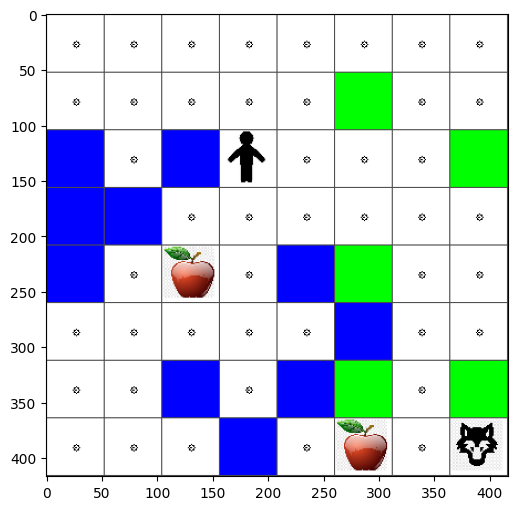

In [20]:
m.plot(Q)

### Essence of Q Learning: Bellman Equation
Once we start moving, each action will have a corresponding reward, i.e. we can theoretically select the next action based on the highest immeadiate reward. However, in most states, the move will not archieve our goal of reaching the apple, and thus we cannot immeadiatelly decide which direction is better.

Remember that it is not the immediate result that matters, but rather the final result, which we will obtain at the end of the simulation.

In order to account for this delayed reward, we need to use the principles of dynamic programming, which allow us to think about out problem recursively.

### Learning algorithm 
Given the equation above, we can now write pseudo-code for our learning algorithm:

* Initialize Q-Table Q with equal numbers for all states and actions
* Set learning rate α ← 1
* Repeat simulation many times
   1. Start at random position
   1. Repeat
        1. Select an action *a* at state *s*
        2. Execute action by moving to a new state *s'*
        3. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        4. Compute reward *r* at the new state
        5. Update Q-Function according to Bellman equation: *Q(s,a)* ← *(1-α)Q(s,a)+α(r+γ max<sub>a'</sub>Q(s',a'))*
        6. *s* ← *s'*
        7. Update the total reward and decrease α.

### Exploit vs. explore

In the algorithm above, we did not specify how exactly we should choose an action at step 2.1. If we are choosing the action randomly, we will randomly **explore** the environment, and we are quite likely to die often as well as explore areas where we would not normally go. An alternative approach would be to **exploit** the Q-Table values that we already know, and thus to choose the best action (with higher Q-Table value) at state *s*. This, however, will prevent us from exploring other states, and it's likely we might not find the optimal solution.

Thus, the best approach is to strike a balance between exploration and exploitation. This can be done by choosing the action at state *s* with probabilities proportional to values in the Q-Table. In the beginning, when Q-Table values are all the same, it would correspond to a random selection, but as we learn more about our environment, we would be more likely to follow the optimal route while allowing the agent to choose the unexplored path once in a while.


### Python implementation
We will need some function that will convert arbitrary numbers in the Q Table into a vector of probabilities for corresponding actions.

In [21]:
def probs(v, eps = 1e-4):
    v = v - v.min() + eps
    v = v / v.sum()
    return v
# added a few eps to the original vector to avoid division by 0 in the initial case, when all components of the vector are identical

Run them learning algorithm through 5000 experiments, also called epochs:

In [23]:

from IPython.display import clear_output

lpath = []


for epoch in range(5000):
    # pick initial point
    m.random_start()

    # start travelling
    n = 0
    cum_reward = 0
    while True:
        x, y = m.human
        v = probs(Q[x, y])
        a = random.choices(list(actions), weights=v)[0]
        dpos = actions[a]
        m.move(dpos, check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r

        if r == end_reward or cum_reward < -1000:
            lpath.append(n)
            break
        
        alpha = np.exp(-n / 10e5)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

After executing this algorithm, the Q-Table should be updated with values that define the attractiveness of different actions at each step. We can try to visualize the Q-Table by plotting a vector at each cell that will point in the desired direction of movement. For simplicity, we draw a small circle instead of an arrow head.

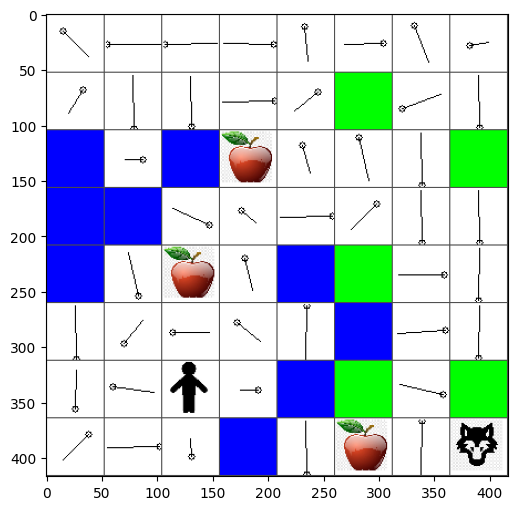

In [24]:
m.plot(Q)

### Checking the policy
Since the Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can select the action corresponding to the highest Q-Table value:

In [25]:
def qpolicy_strict(m):
    x, y = m.human
    v = probs(Q[x, y])
    a = list(actions)[np.argmax(v)]
    return a

walk(m, qpolicy_strict)

1

If you try the code above several times, you may notice that sometimes it "hangs", and you need to press the STOP button in the notebook to interrupt it. This happens because there could be situations when two states "point" to each other in terms of optimal Q-Value, in which case the agents ends up moving between those states indefinitely.

## 🚀Challenge

> **Task 1:** Modify the `walk` function to limit the maximum length of path by a certain number of steps (say, 100), and watch the code above return this value from time to time.

> **Task 2:** Modify the `walk` function so that it does not go back to the places where it has already been previously. This will prevent `walk` from looping, however, the agent can still end up being "trapped" in a location from which it is unable to escape.

### Navigation
A better navigation policy would be the one that we used during training, which combines exploitation and exploration. In this policy, we will select each action with a certain probability, proportional to the values in the Q-Table. This strategy may still result in the agent returning back to a position it has already explored, but, as you can see from the code below, it results in a very short average path to the desired location (remember that print_statistics runs the simulation 100 times)

In [ ]:
def qpolicy(m):
    x,y = m.human
    v = probs(Q[x,y])
    a = random.choices(list(actions), weights=v)[0]
    return a

print_statistics(qpolicy)

Average path length = 5.313131313131313, eaten by wolf: 1 times


After running this code, you should get a much smaller average path length than before, in the range of 3-6.